## Report No.04 Runge-Kutta-Fehlberg法について
### 1.Runge-Kutta-Fehlberg法での「誤差の推定」について考察する
オイラー法やルンゲ・クッタ法では刻み幅$\Delta t$ が固定である。  
特に、オイラー法ではその$\Delta t$の値によっては計算結果が発散してしまったりと不安定な場合がある。  
では刻み幅$\Delta t$を可能な限り小さな値に設定すれば万事解決かと言われるとそうではなく、計算コストが大きくなってしまうため最善策とは言えない。  

そこで、効率的で精度の良い計算結果を得るために刻み幅を適切に設定、制御することが求められる。具体的には、関数の変化が小さなところでは刻み幅を大きくとることで計算コストを削減し、関数の変化が大きいところでは刻み幅を小さくしてその変化を丁寧に追っていく、という風に関数の変化量に応じて最適な刻み幅を推定するのである。  
ここで問題になるのは、関数の変化の大小をどのように評価するのかということである。

ところで、Runge-Kutta-Fehlberg法は$t$から$t+\Delta t$ の間の関数の時間変化$r$の近似値を 6つ計算するような6段5次のRunge-Kutta法である。
この公式を用いると、係数を工夫することによって以下のように5次オーダと4次オーダの2つの近似解を得ることができる。

- 5次オーダの解
\begin{equation}
 u_{n+1}^{(5)} = u_n+T\{(16/135)r_1+(6656/12825)r_3+(28561/56430)r_4-(9/50)r_5+(2/55)r_6\}
\end{equation}

- 4次オーダの解
\begin{equation}
 u_{n+1}^{(4)} = u_n+T\{(25/216)r_1+(1408/2565)r_3+(2197/4104)r_4-(1/5)r_5\}
\end{equation}

先の問題に戻ろう。  
関数の変化の大小は $|u_{n+1}^{(5)}-u_{n+1}^{(4)}|$ で評価することができる。なぜなら、精度のより良い計算である5次オーダの近似解と、それよりも精度の劣る4次オーダの近似解との差は関数の変化の程度を反映していると考えられるからである。(この近似解の差は”推定された誤差”と言うこともできるであろう。)したがって、この近似解の差がある基準よりも大きければ刻み幅を小さくするという工程を踏むことで刻み幅の制御が可能になる。

### 2. Runge-Kutta-Fehlberg法を実装する
まず、RKF法を以下のように関数として定義した。  
4次近似値と5次近似値を返り値とした。

In [1]:
function RKF(u)
    r1 = r(u)
    r2 = r(u + ((Δt/4) * r1))
    r3 = r(u +(((3/32) * r1) +((9/32) * r2))*Δt)
    r4 = r(u + (((1932/2197) * r1) +((-7200/2197) * r2) +((7296/2197) * r3)) * Δt)
    r5 = r(u + (((439/216) * r1) - (8 * r2) + ((3680/513) * r3) +((-845/4104) * r4)) * Δt)
    r6 = r(u + (((-8/27) * r1) + (2 * r2) +((-3544/2565) * r3) +((1859/4104) * r4) + ((-11/40) * r5)) * Δt )
    u4 =  u + (Δt * (((25/216) * r1) + ((1408/2565) * r3) + ((2197/4104) * r4) + ((-1/5) * r5)))
    u5 =  u + (Δt * (((16/135) * r1) + ((6656/12825) * r3) + ((28561/56430) * r4) + ((-9/50) * r5) + ((2/55) * r6)))
    return u4, u5
end

RKF (generic function with 1 method)

次に初期値を設定する。  
uの初期値は0.1、$\Delta t$の初期値は0.5とした。  
後々使う配列と、誤差の評価に使用する係数$C_R$と$C_S$もこのときに定義した。

In [3]:
using Plots
gr()

r(u) = (sin(u))^(1.2)

u0 = 0.10         #初期値を設定
u_sq = [u0]
u = u0

Δt = 0.5         #初期値を設定
Δt_sq = [0.5]
Δt_opt = Δt
abs_sq = [0.0]

t = 0.0
t_sq = [0.0]

n_sq = [0]

norm_sq = [0.0]

Cr = 1.0e-6    #誤差を評価する係数の値を定義する
Cs = 1.0e-10

1.0e-10

以上のように定義した関数と初期値を用いて、以下のようにRKF法によって解を求めた。  

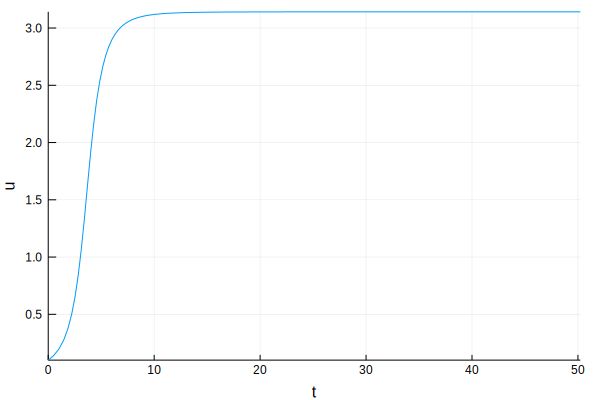

u:3.1415824918796065    t:50.223419381728746    n:97   Deltat:0.9999999862306438


In [4]:
for n in 1:200
    u4, u5 = RKF(u)   #Runge-Kutta-Fehlberg法で次の値を求める
    push!(u_sq, u4)
    push!(Δt_sq,Δt)
    push!(n_sq,n)
    push!(norm_sq, norm(u4-u5))
    t += Δt
    push!(t_sq, t)
    
    if norm(u4-u5) > Cr   　　　　　　　　　　 #4次近似値の誤差がCrよりも大きければ
        Δt_opt = ((Cr/norm(u4-u5))^(1/5))*Δt     #Δtの値を調整する

    elseif norm(u4-u5) < Cs                    #4次近似値の誤差がCsよりも小さければ
        Δt_opt = ((Cs/norm(u4-u5))^(1/5))*Δt     #Δtの値を調整する
    else
        Δt_opt = Δt
    end
    
    δt = abs(Δt_opt-Δt)
    push!(abs_sq, δt)
    
    Δt_opt = (1-(δt/(1+δt)))*Δt_opt             #安全係数をかける
    Δt = Δt_opt     #Δtを更新する
    
    if (norm(u4-u))/Δt < 1.0e-6                  #tに対するuの変化量がほぼ0のとき、解が求まったとして
        println("u:",u,"    t:",t,"    n:",n,"   Deltat:",Δt)     #最終的に求まった解とそのときのt、ステップ数を表示してから
        break                                    #forループを抜ける
    end
    
    u = u4             #uをu4に更新する
end

plot(t_sq, u_sq, xaxis = "t", yaxis = "u", leg = false)   #tに対するuのプロット

以上の結果から、このRKF法の実装によって求まった解はu=3.1415824918796065 であり、ステップ数は97であった。  
0.5から始めた刻み幅は最終的に0.9999999862306438となった。
刻み幅$\Delta t$を調整するアルゴリズムとして、  
4次近似値Uの誤差$||U_4-U_5||$が$C_R$より大きければ

\begin{equation}
\Delta t_{opt} = \left(\frac{C_R}{||U_4-U_5||}\right)^{1/5}\Delta t
\end{equation}

とし、逆に4次近似値Uの誤差$||U_4-U_5||$が$C_S$より小さければ

\begin{equation}
\Delta t_{opt} = \left(\frac{C_S}{||U_4-U_5||}\right)^{1/5}\Delta t
\end{equation}

とした。  
こうすることによって、誤差が大きな時には刻み幅を小さくし、逆に誤差が十分に小さい、すなわちtに対するuの変化が小さいときには刻み幅を大きくとることができるので、計算コストが節約できると考えた。  
また、刻み幅の急激な変化を避けるため、

\begin{equation}
\Delta t_{opt} = \left(1-\left(\frac{\delta t}{1+\delta t}\right)\right)\Delta t_{opt}
\end{equation}

とした。ここで、$\delta t$というのは、$| \Delta t_{opt} -\Delta t |$であり、今回のステップでの刻み幅と前のステップ時の刻み幅の差の絶対値をとったものである。  
刻み幅の変化が大きい時には$\left(1-\left(\frac{\delta t}{1+\delta t}\right)\right)$が小さくなるためこの安全係数によって刻み幅の急激な変化を緩和しようと試みた。
また、比較対象として、刻み幅を変化させずに計算した場合を考える。  
刻み幅$\Delta t$は0.2とした。
ここでの終了判定も先と同じように、tに対するuの変化量が $10^{-6}$より小さければforループを抜けるようにした。

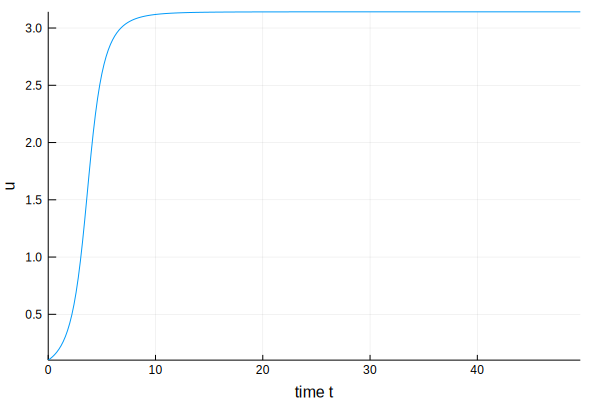

u:3.1415826699176166    t:49.6    n:248


In [6]:
#刻み幅が一定の場合

u02 = 0.10
u_sq2 = [u0]
u = u02
Δt = 0.2
t = 0.0
t_sq2 = [0.0]

for n in 1:1000
    u4, u5 = RKF(u)
    push!(u_sq2, u4)
    push!(t_sq2, n*Δt)
    
    if (norm(u4-u))/Δt < 1.0e-6 #tに対するuの変化量がほぼ0のとき、解が求まったとして
        println("u:",u,"    t:",n*Δt,"    n:",n)     #最終的に求まった解とそのときのt、nを表示
        break                    #forループを抜ける
    end
    u = u4
end

plot(t_sq2, u_sq2, xaxis = "time t", yaxis = "u", leg = false)

以上の結果より、刻み幅を一定にした場合の解は3.1415826699176166、ステップ数は248となることが分かる。  
刻み幅を制御した場合との解の差は1.780380101124024e-7である。  
この結果から、刻み幅の制御によって、刻み幅を制御しない場合の解と同程度の精度の解を、より少ないステップ数すなわち少ない計算コストによって得ることができたと言える。